# Make cuts on the non-periodic stars.

Reproducing data.py in kinematics-and-rotation (which is based on Exploring_data.ipynb in kinematics-and-rotation).

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.utils as au
from astropy.coordinates import SkyCoord
from dustmaps.bayestar import BayestarQuery
import astropy.units as units
from tools import getDust
from stardate.lhf import age_model
from calc_velocities import calc_vb, calc_vz, calc_vl
import astropy.units as u
from astropy.coordinates import ICRS
from astropy.coordinates import Galactic
from astropy.table import Table
from pyia import GaiaData
import astropy.coordinates as coord
from photometric_teff import bprp_to_teff

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load McQuillan data.

In [2]:
mc = pd.read_csv("../data/Table_2_Non_Periodic.txt")

Load Gaia catalog and merge.

In [3]:
with fits.open("../data/kepler_dr2_1arcsec.fits") as data:
    gaia = pd.DataFrame(data[1].data, dtype="float64")

gaia_mc = pd.merge(mc, gaia, left_on="KID", right_on="kepid", how="left")

S/N and other quality cuts.

In [4]:
sn = gaia_mc.parallax.values/gaia_mc.parallax_error.values

m = (sn > 10)
m &= (gaia_mc.parallax.values > 0) * np.isfinite(gaia_mc.parallax.values)
m &= gaia_mc.astrometric_excess_noise.values < 5
gaia_mc = gaia_mc.iloc[m]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


Load Dustmaps and calculate reddening and extinction.

In [5]:
bayestar = BayestarQuery(max_samples=2, version='bayestar2019')

coords = SkyCoord(gaia_mc.ra.values*units.deg, gaia_mc.dec.values*units.deg,
                  distance=gaia_mc.r_est.values*units.pc)

ebv, flags = bayestar(coords, mode='percentile', pct=[16., 50., 84.],
                      return_flags=True)

# Calculate Av
Av_bayestar = 2.742 * ebv
Av = Av_bayestar[:, 1]
Av_errm = Av - Av_bayestar[:, 0]
Av_errp = Av_bayestar[:, 2] - Av
Av_std = .5*(Av_errm + Av_errp)

# Catch places where the extinction uncertainty is zero and default to an
# uncertainty of .05
m = Av_std == 0
Av_std[m] = .05

gaia_mc["ebv"] = ebv[:, 1]  # The median ebv value.
gaia_mc["Av"] = Av
gaia_mc["Av_errp"] = Av_errp
gaia_mc["Av_errm"] = Av_errm
gaia_mc["Av_std"] = Av_std

# Calculate dereddened photometry
AG, Abp, Arp = getDust(gaia_mc.phot_g_mean_mag.values,
                       gaia_mc.phot_bp_mean_mag.values,
                       gaia_mc.phot_rp_mean_mag.values, gaia_mc.ebv.values)

gaia_mc["bp_dered"] = gaia_mc.phot_bp_mean_mag.values - Abp
gaia_mc["rp_dered"] = gaia_mc.phot_rp_mean_mag.values - Arp
gaia_mc["bprp_dered"] = gaia_mc["bp_dered"] - gaia_mc["rp_dered"]
gaia_mc["G_dered"] = gaia_mc.phot_g_mean_mag.values - AG

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 20.317 s
  pix_info:   0.466 s
   samples:   8.862 s
      best:   4.201 s
       nan:   0.169 s
      sort:   6.399 s
       idx:   0.220 s


Calculate Absolute magnitude.

In [7]:
def mM(m, D):
    return 5 - 5*np.log10(D) + m

abs_G = mM(gaia_mc.G_dered.values, gaia_mc.r_est)
gaia_mc["abs_G"] = abs_G

Remove NaNs.

In [8]:
m2 = np.isfinite(gaia_mc.abs_G.values)
gaia_mc = gaia_mc.iloc[m2]

Remove subgiants.

In [11]:
# Remove binaries
x = gaia_mc.bp_dered - gaia_mc.rp_dered
y = gaia_mc.abs_G

# AT = np.vstack((x**6, x**5, x**4, x**3, x**2, x, np.ones_like(x)))
# ATA = np.dot(AT, AT.T)
# w = np.linalg.solve(ATA, np.dot(AT, y))

# minb, maxb, extra = 0, 2.2, .27
# xs = np.linspace(minb, maxb, 1000)
subcut = 4.5

# m = (minb < x) * (x < maxb)
# m &= (y < np.polyval(w, x) - extra) + (subcut > y)


# Calculate photometric Teff
teffs = bprp_to_teff(gaia_mc.bp_dered - gaia_mc.rp_dered)
gaia_mc["color_teffs"] = teffs

m = (subcut < y) * (teffs < 6250)

flag = np.zeros(len(gaia_mc))
flag[m] = np.ones(len(flag[m]))
gaia_mc["flag"] = flag

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


(0.4, 2)

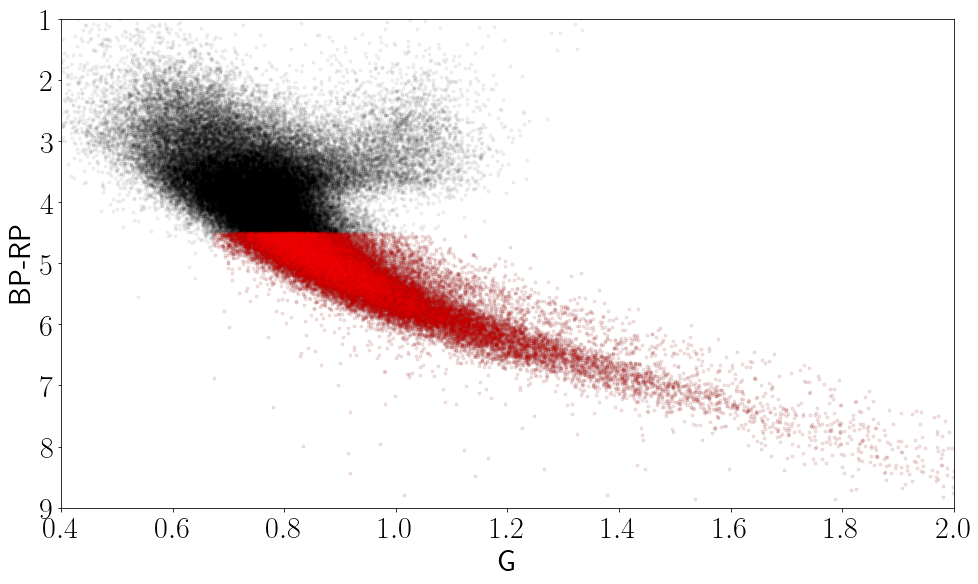

In [13]:
plt.figure(figsize=(16, 9))
plt.plot(x, y, "k.", alpha=.05)
plt.plot(x[m], y[m], "r.", alpha=.05)
# xs = np.linspace(.5, 2, 100)
# plt.plot(xs, np.polyval(w, xs))
# plt.plot(xs, np.polyval(w, xs) - extra)
plt.xlabel("G")
plt.ylabel("BP-RP")
plt.ylim(9, 1)
plt.xlim(.4, 2)

Calculate gyro ages.

In [14]:
logages = []
for i, p in enumerate(gaia_mc.Prot.values):
    logages.append(age_model(np.log10(p), gaia_mc.phot_bp_mean_mag.values[i] -
                             gaia_mc.phot_rp_mean_mag.values[i]))
gaia_mc["log_age"] = np.array(logages)
gaia_mc["age"] = (10**np.array(logages))*1e-9

(0.4, 2)

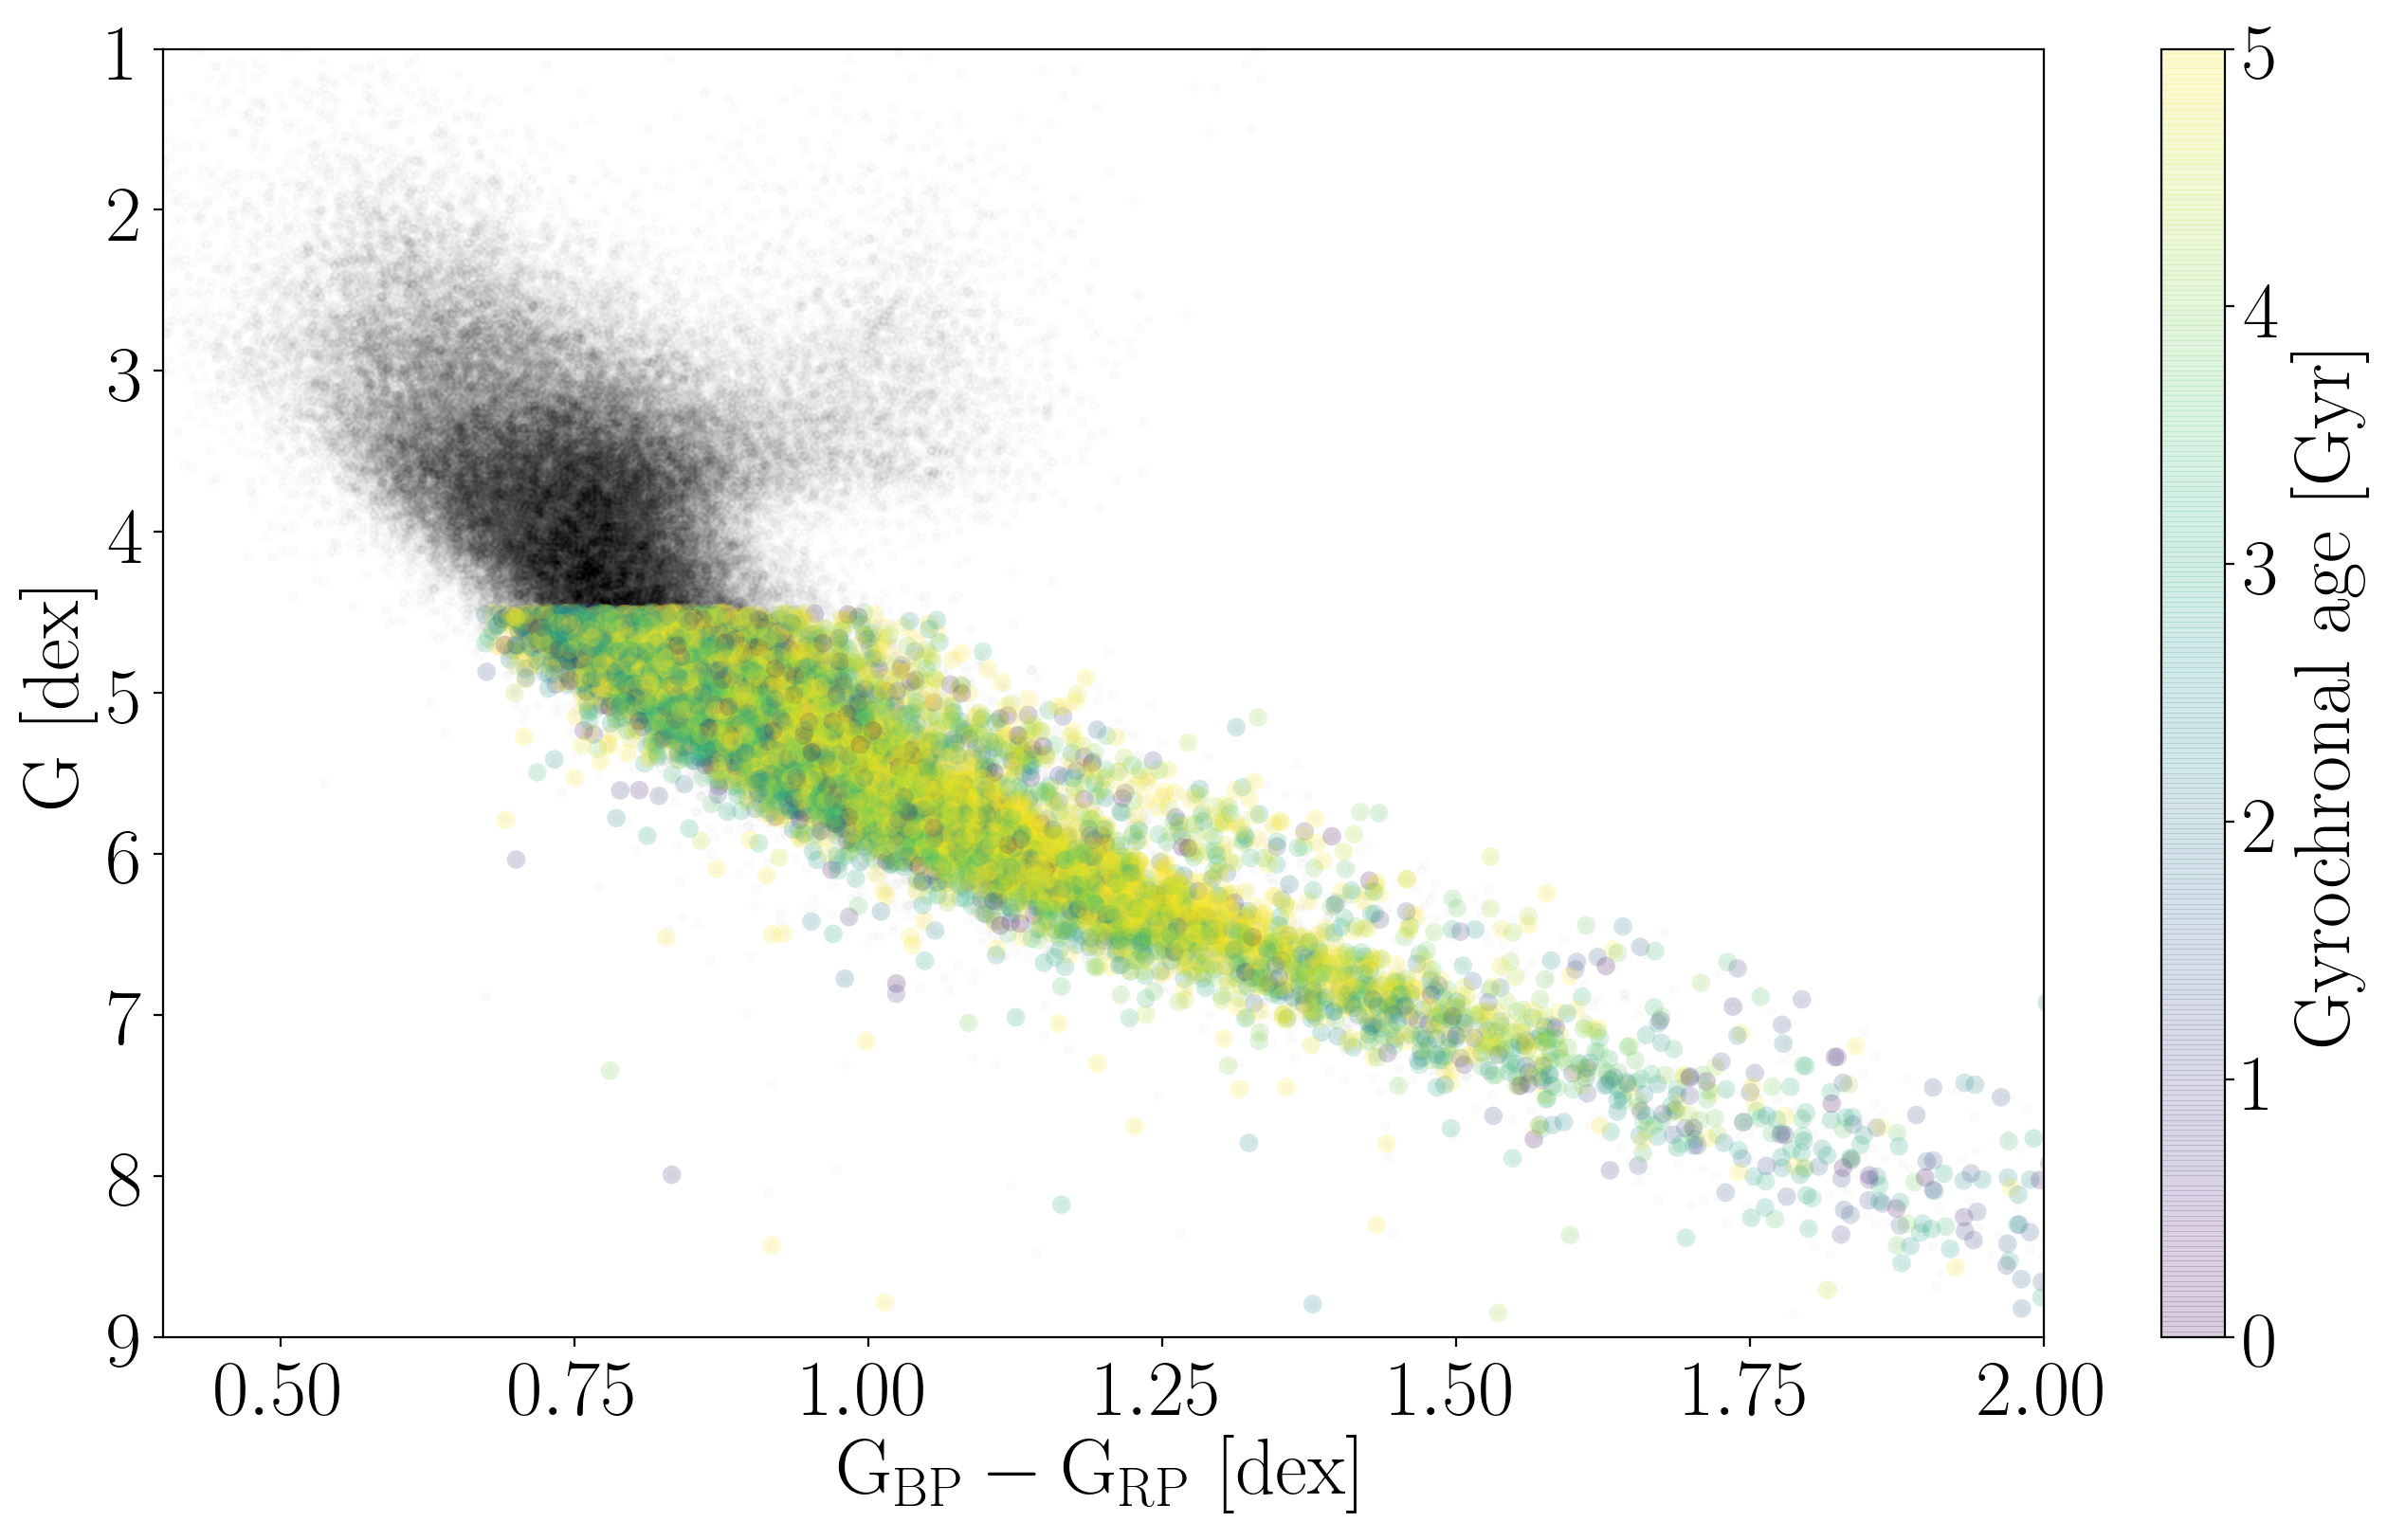

In [15]:
plt.figure(figsize=(16, 9), dpi=200)
singles = gaia_mc.flag.values == 1

plt.plot(gaia_mc.bprp_dered.values, gaia_mc.abs_G.values, "k.", alpha=.01,
         zorder=0)

plt.scatter(gaia_mc.bprp_dered.values[singles], gaia_mc.abs_G.values[singles],
            c=gaia_mc.age.values[singles], vmin=0, vmax=5, s=50, alpha=.2,
            cmap="viridis", rasterized=True, edgecolor="none", zorder=1)
plt.xlabel("$\mathrm{G_{BP}-G_{RP}~[dex]}$")
plt.ylabel("$\mathrm{G~[dex]}$")
plt.colorbar(label="$\mathrm{Gyrochronal~age~[Gyr]}$")
plt.ylim(9, 1)
plt.xlim(.4, 2)

Calculate vb.

In [16]:
pmb_samples, vb_samples = calc_vb(gaia_mc)
pmb, vb = np.median(pmb_samples, axis=1), np.median(vb_samples, axis=1)
pmb_err, vb_err = np.std(pmb_samples, axis=1), np.std(vb_samples, axis=1)
vb_errp = np.percentile(vb_samples, 84, axis=1) - vb
vb_errm = vb - np.percentile(vb_samples, 16, axis=1)
gaia_mc["vb"] = vb
gaia_mc["vb_err"] = vb_err

And other velocities.

In [17]:
# print("Calculating vl")
# vl_samples = calc_vl(gaia_mc)
# vl, vl_err = np.median(vl_samples, axis=1), np.std(vl_samples, axis=1)
# vl_errp = np.percentile(vl_samples, 84, axis=1) - vl
# vl_errm = vl - np.percentile(vl_samples, 16, axis=1)
# gaia_mc["vl"] = vl
# gaia_mc["vl_err"] = vl_err

# Calculate b
icrs = ICRS(ra=gaia_mc.ra.values*u.degree,
            dec=gaia_mc.dec.values*u.degree)
lb = icrs.transform_to(Galactic)
b = lb.b*u.degree
l = lb.l*u.degree
gaia_mc["b"] = b.value
gaia_mc["l"] = l.value

print("Calculating VZ")
mrv = gaia_mc.radial_velocity.values != 0.00
vz, vz_err = calc_vz(gaia_mc)
vz[~mrv] = np.ones(len(vz[~mrv]))*np.nan
vz_err[~mrv] = np.ones(len(vz_err[~mrv]))*np.nan
gaia_mc["vz"] = vz
gaia_mc["vz_err"] = vz_err

# Calculate v_ra and v_dec
d = gaia_mc.r_est.values*u.pc

vra = (gaia_mc.pmra.values*u.mas/u.yr * d).to(u.km/u.s,
                                              u.dimensionless_angles())
vdec = (gaia_mc.pmdec.values*u.mas/u.yr * d).to(u.km/u.s,
                                                u.dimensionless_angles())

c = coord.SkyCoord(ra=gaia_mc.ra.values*u.deg, dec=gaia_mc.dec.values*u.deg,
                   distance=d, pm_ra_cosdec=gaia_mc.pmra.values*u.mas/u.yr,
                   pm_dec=gaia_mc.pmdec.values*u.mas/u.yr)
gal = c.galactic
v_b = (gal.pm_b * gal.distance).to(u.km/u.s, u.dimensionless_angles())
gaia_mc["v_ra"] = vra.value
gaia_mc["v_dec"] = vdec.value
gaia_mc["v_b"] = v_b

Calculating VZ


Save file.

In [20]:
dwarfs = gaia_mc.flag.values == 1
gaia_mc_dwarfs = gaia_mc.iloc[dwarfs]

In [21]:
print(np.shape(gaia_mc_dwarfs))

(33512, 131)


In [22]:
gaia_mc_dwarfs.to_csv("gaia_mc_non_periodic.csv")

(0.4, 2)

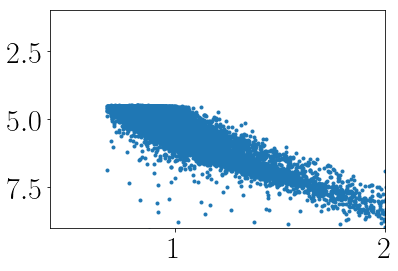

In [25]:
plt.plot(gaia_mc_dwarfs.bprp_dered, gaia_mc_dwarfs.abs_G, ".")
plt.ylim(9, 1)
plt.xlim(.4, 2)